In [ ]:
 import tensorflow as tf

def data_process(batch_size):
    # 훈련 데이터셋 경로 설정
    train_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_train'  # 훈련 데이터 경로
    val_data_path = '//content/drive/Othercomputers/내 PC/TEST_1/mask_val'      # 검증 데이터 경로

    # 훈련 데이터셋 생성: 디렉토리 구조에 따라 라벨 자동 생성
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=True
    )

    # 검증 데이터셋 생성
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=False
    )

    # 표준화 (Normalization) 추가
    # 입력 이미지의 평균과 표준편차를 사용하여 데이터 표준화
    standardization_layer = tf.keras.layers.Rescaling(1./255)  # 이미지를 0-1 범위로 표준화
    train_dataset = train_dataset.map(lambda x, y: (standardization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (standardization_layer(x), y))

    # 데이터 증강 (augmentation) 추가: 훈련 데이터에 여러가지 변형을 추가
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),   # 랜덤 좌우 반전
        tf.keras.layers.RandomRotation(0.2),        # 랜덤 회전
        tf.keras.layers.RandomZoom(0.1),            # 랜덤 확대/축소
        tf.keras.layers.RandomContrast(0.2),        # 랜덤 대비 변화
        tf.keras.layers.RandomBrightness(0.2)       # 랜덤 밝기 변화
    ])

    # 훈련 데이터에 데이터 증강을 적용
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    # 검증 데이터에는 증강을 적용하지 않음
    # 검증 데이터는 오직 표준화만 진행
    # val_dataset = val_dataset.map(lambda x, y: (standardization_layer(x), y))

    return train_dataset, val_dataset


Found 5994 files belonging to 4 classes.


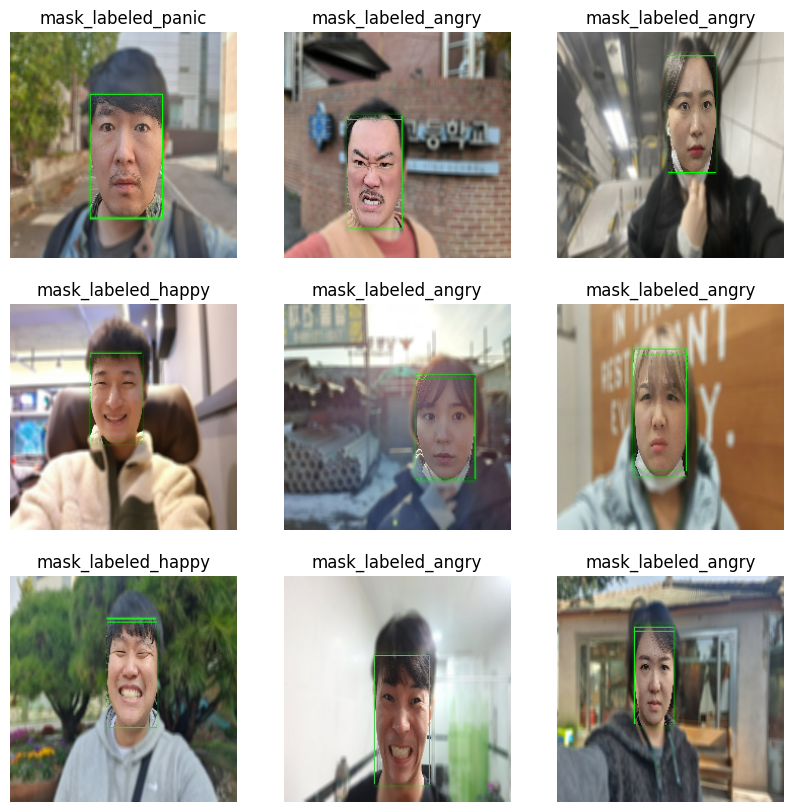

In [ ]:
import matplotlib.pyplot as plt

# 원본 데이터셋에서 클래스 이름 가져오기
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/Othercomputers/내 PC/TEST_1/mask_train',
    image_size=(224, 224),
    batch_size=32
)

class_names = raw_train_dataset.class_names  # 클래스 이름 저장

# 데이터셋 확인
plt.figure(figsize=(10, 10))
for images, labels in raw_train_dataset.take(1):  # 한 배치만 가져오기
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    break


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def data_process(batch_size):
    # 경로 수정
    train_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_train'
    val_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_val'

    # 데이터셋 생성
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=True
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=False
    )

    # 표준화 (0-1 스케일)
    standardization_layer = tf.keras.layers.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (standardization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (standardization_layer(x), y))

    # 데이터 증강
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.2)
    ])

    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    return train_dataset, val_dataset

def create_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = tf.keras.applications.EfficientNetB2(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    base_model.trainable = True  # 사전 훈련된 모델의 가중치 동결 해제

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # 학습률 감소 적용
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # 기본값 0.001 → 0.0001로 감소

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 데이터셋 준비
batch_size = 32
train_dataset, val_dataset = data_process(batch_size)

# 모델 생성
model = create_model(input_shape=(224, 224, 3), num_classes=4)

# 콜백 설정 (EarlyStopping & ReduceLROnPlateau)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 모델 학습
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping, reduce_lr])


Found 5994 files belonging to 4 classes.
Found 1200 files belonging to 4 classes.
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 246s 727ms/step - accuracy: 0.3601 - loss: 1.3099 - val_accuracy: 0.2492 - val_loss: 1.4465 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.6375 - loss: 0.9072 - val_accuracy: 0.3633 - val_loss: 1.3307 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.7041 - loss: 0.7264 - val_accuracy: 0.2558 - val_loss: 1.4624 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 436ms/step - accuracy: 0.7541 - loss: 0.6175 - val_accuracy: 0.2500 - val_loss: 1.4522 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 436ms/step - accuracy: 0.7825 - loss: 0.5488 - val_accuracy: 0.4158 - val_loss: 1.3229 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.8060 - loss: 0.5036 - val_accuracy: 0.3908 - val_loss

In [ ]:
# 모델 저장
model.save('/content/drive/MyDrive/TEST_1efficientnet_b2_model.keras')  # 원하는 경로로 저장


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def data_process(batch_size):
    # 경로 수정
    train_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_train'
    val_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_val'

    # 데이터셋 생성
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=True
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=False
    )

    # 표준화 (0-1 스케일)
    standardization_layer = tf.keras.layers.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (standardization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (standardization_layer(x), y))

    # 데이터 증강
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.2)
    ])

    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    return train_dataset, val_dataset

def create_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = tf.keras.applications.EfficientNetB2(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    base_model.trainable = True  # 사전 훈련된 모델의 가중치 동결 해제

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # 학습률 감소 적용
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # 기본값 0.001 → 0.0001로 감소

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 데이터셋 준비
batch_size = 32
train_dataset, val_dataset = data_process(batch_size)

# 모델 생성
model = create_model(input_shape=(224, 224, 3), num_classes=4)

# 콜백 설정 (EarlyStopping & ReduceLROnPlateau)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 모델 학습
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping, reduce_lr])


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def data_process(batch_size):
    # 경로 수정
    train_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_train'
    val_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_val'

    # 데이터셋 생성
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=True
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=False
    )

    # 표준화 (0-1 스케일)
    standardization_layer = tf.keras.layers.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (standardization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (standardization_layer(x), y))

    # 데이터 증강
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.2)
    ])

    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    return train_dataset, val_dataset

def create_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = tf.keras.applications.EfficientNetV2B0(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    base_model.trainable = True  # 사전 훈련된 모델의 가중치 동결 해제

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # 학습률 감소 적용
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # 기본값 0.001 → 0.0001로 감소

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 데이터셋 준비
batch_size = 32
train_dataset, val_dataset = data_process(batch_size)

# 모델 생성
model = create_model(input_shape=(224, 224, 3), num_classes=4)

# 콜백 설정 (EarlyStopping & ReduceLROnPlateau)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 모델 학습
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping, reduce_lr])


Found 5994 files belonging to 4 classes.
Found 1200 files belonging to 4 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.3118 - loss: 1.3567 - val_accuracy: 0.3017 - val_loss: 1.4029 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.5763 - loss: 1.0157 - val_accuracy: 0.4750 - val_loss: 1.2101 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 433ms/step - accuracy: 0.6684 - loss: 0.8132 - val_accuracy: 0.5608 - val_loss: 1.0740 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.7003 - loss: 0.7162 - val_accuracy: 0.6558 - val_loss: 0.8641 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 433ms/step - accuracy: 0.7344 - loss: 0.6566 - val_accuracy: 0.5200 - val_loss: 1.0931 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.7646 

In [ ]:
# 모델 저장
model.save("efficientnet_v2b0_model.keras")


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def data_process(batch_size):
    # 경로 수정
    train_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_train'
    val_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_val'

    # 데이터셋 생성
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=True
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=False
    )

    # 표준화 (0-1 스케일)
    standardization_layer = tf.keras.layers.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (standardization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (standardization_layer(x), y))

    # 데이터 증강
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.2)
    ])

    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    return train_dataset, val_dataset

def create_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = tf.keras.applications.EfficientNetV2M(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    base_model.trainable = True  # 사전 훈련된 모델의 가중치 동결 해제

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # 학습률 감소 적용
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # 기본값 0.001 → 0.0001로 감소

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 데이터셋 준비
batch_size = 32
train_dataset, val_dataset = data_process(batch_size)

# 모델 생성
model = create_model(input_shape=(224, 224, 3), num_classes=4)

# 콜백 설정 (EarlyStopping & ReduceLROnPlateau)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 모델 학습
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping, reduce_lr])
# 모델 저장
model.save("efficientnet_v2bM_model.keras")


Found 5994 files belonging to 4 classes.
Found 1200 files belonging to 4 classes.
214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.4084 - loss: 1.2525 - val_accuracy: 0.5975 - val_loss: 1.0091 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 437ms/step - accuracy: 0.6837 - loss: 0.7832 - val_accuracy: 0.6817 - val_loss: 0.8341 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.7524 - loss: 0.6325 - val_accuracy: 0.6883 - val_loss: 0.8357 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.7911 - loss: 0.5431 - val_accuracy: 0.6242 - val_loss: 1.1625 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8028 - loss: 0.5073
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 433ms/step - accuracy: 0.8028 - l

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def data_process(batch_size):
    # 경로 수정
    train_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_train'
    val_data_path = '/content/drive/Othercomputers/내 PC/TEST_1/mask_val'

    # 데이터셋 생성
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=True
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_data_path,
        image_size=(224, 224),
        batch_size=batch_size,
        shuffle=False
    )

    # 표준화 (0-1 스케일)
    standardization_layer = tf.keras.layers.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (standardization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (standardization_layer(x), y))

    # 데이터 증강
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.2)
    ])

    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    return train_dataset, val_dataset

def create_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    base_model.trainable = True  # 사전 훈련된 모델의 가중치 동결 해제

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # 학습률 감소 적용
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # 기본값 0.001 → 0.0001로 감소

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 데이터셋 준비
batch_size = 32
train_dataset, val_dataset = data_process(batch_size)

# 모델 생성
model = create_model(input_shape=(224, 224, 3), num_classes=4)

# 콜백 설정 (EarlyStopping & ReduceLROnPlateau)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# 모델 학습
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping, reduce_lr])

# 모델 저장
model.save("resnet50_model.keras")


Found 5994 files belonging to 4 classes.
Found 1200 files belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.4680 - loss: 1.2121 - val_accuracy: 0.2500 - val_loss: 4.4707 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.7171 - loss: 0.7318 - val_accuracy: 0.2500 - val_loss: 5.5035 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 433ms/step - accuracy: 0.7648 - loss: 0.6099 - val_accuracy: 0.2542 - val_loss: 1.6472 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.8057 - loss: 0.5145 - val_accuracy: 0.4725 - val_loss: 1.5887 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 433ms/step - accuracy: 0.8239 - loss: 0.4799 - val_accuracy: 0.6767 - val_loss: 0.9949 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.8499 

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

model_path = "/content/resnet50_model.keras"
model = tf.keras.models.load_model(model_path)
print("✅ 모델이 로드되었습니다.")


# 감정 클래스
class_names = ['happy', 'sadness', 'angry', 'panic']

# 이미지 폴더 경로
image_folder = r"/content/drive/Othercomputers/내 PC/TEST_1/test/image-20250212T014410Z-001/image/angry"

# Haarcascade 모델 로드
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# 폴더 내 모든 JPG 파일 가져오기
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(".jpg")]

if not image_files:
    print("❌ 이미지 파일이 폴더에 없습니다.")
else:
    total_accuracy = 0
    total_images = 0

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

            if len(faces) > 0:
                # 블러 적용된 배경 이미지 생성
                blurred_image = cv2.GaussianBlur(image, (55, 55), 30)

                for (x, y, w, h) in faces:
                    face_roi = image[y:y+h, x:x+w]  # 원본 얼굴 영역 추출
                    blurred_image[y:y+h, x:x+w] = face_roi  # 블러된 이미지 위에 얼굴 원본 덮어쓰기

                    # 얼굴 이미지 전처리
                    face_resized = cv2.resize(face_roi, (224, 224))
                    face_array = img_to_array(face_resized)
                    face_array = np.expand_dims(face_array, axis=0) / 255.0  # 정규화

                    # 감정 분석 실행
                    predictions = model.predict(face_array)
                    predicted_class = np.argmax(predictions)
                    confidence = np.max(predictions)

                    # 정확도 계산
                    total_accuracy += confidence * 100
                    total_images += 1

                    # 예측된 감정 표시
                    label = f"{class_names[predicted_class]} ({confidence*100:.2f}%)"
                    cv2.putText(blurred_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                    cv2.rectangle(blurred_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # 결과 이미지 저장 (원하는 경로 설정)
                output_path = os.path.join(image_folder, f"processed_{image_file}")
                cv2.imwrite(output_path, blurred_image)

    if total_images > 0:
        avg_accuracy = total_accuracy / total_images
        print(f"✅ 전체 이미지 평균 분류 정확도: {avg_accuracy:.2f}%")
    else:
        print("❌ 얼굴이 감지되지 않았습니다.")


✅ 모델이 로드되었습니다.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

✅ 모델이 로드되었습니다.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

model_path = "/content/resnet50_model.keras"
model = tf.keras.models.load_model(model_path)
print("✅ 모델이 로드되었습니다.")


# 감정 클래스
class_names = ['happy', 'sadness', 'angry', 'panic']

# 이미지 폴더 경로
image_folder = r"/content/drive/Othercomputers/내 PC/TEST_1/test/image-20250212T014410Z-001/image/happy"

# Haarcascade 모델 로드
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# 폴더 내 모든 JPG 파일 가져오기
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(".jpg")]

if not image_files:
    print("❌ 이미지 파일이 폴더에 없습니다.")
else:
    total_accuracy = 0
    total_images = 0

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

            if len(faces) > 0:
                # 블러 적용된 배경 이미지 생성
                blurred_image = cv2.GaussianBlur(image, (55, 55), 30)

                for (x, y, w, h) in faces:
                    face_roi = image[y:y+h, x:x+w]  # 원본 얼굴 영역 추출
                    blurred_image[y:y+h, x:x+w] = face_roi  # 블러된 이미지 위에 얼굴 원본 덮어쓰기

                    # 얼굴 이미지 전처리
                    face_resized = cv2.resize(face_roi, (224, 224))
                    face_array = img_to_array(face_resized)
                    face_array = np.expand_dims(face_array, axis=0) / 255.0  # 정규화

                    # 감정 분석 실행
                    predictions = model.predict(face_array)
                    predicted_class = np.argmax(predictions)
                    confidence = np.max(predictions)

                    # 정확도 계산
                    total_accuracy += confidence * 100
                    total_images += 1

                    # 예측된 감정 표시
                    label = f"{class_names[predicted_class]} ({confidence*100:.2f}%)"
                    cv2.putText(blurred_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                    cv2.rectangle(blurred_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # 결과 이미지 저장 (원하는 경로 설정)
                output_path = os.path.join(image_folder, f"processed_{image_file}")
                cv2.imwrite(output_path, blurred_image)

    if total_images > 0:
        avg_accuracy = total_accuracy / total_images
        print(f"✅ 전체 이미지 평균 분류 정확도: {avg_accuracy:.2f}%")
    else:
        print("❌ 얼굴이 감지되지 않았습니다.")
